# **NEURAL NETWORK USING STOCHASTIC GRADIENT DESCENT**
by **Jean Carlo Codogno** - 17/03/2018

<br/>

+ **INTRODUCTION**
    + **DATA EXPLORATION**
        + IMPORT THE DATASET
        + VISUALIZATION OF THE DATA
        + COUNT OF EXAMPLES PER DIGIT
        + NORMALIZATION
        + ONE HOT ENCODING
    + **DESCRIBE THE MODEL**
        + ACTIVATION FUNCTIONS
        + DESCRIBE THE MODEL
            + CREATING WEIGHTS
            + DROPOUT
            + PREDICT
            +  METRICS
            + CROSS - VALIDATION

    + **TRAINING**
        + SGD (Stochastic Gradient Descent)
        + MOMENTUM
        + L2 REGULIZER


## INTRODUCTION

This is a simple Fully Connected  Neural Network using Stochastic Gradient Descent to train it. We use 2 hidden layer with activation function relu and 1 output layer with activation function softmax for classification. 

## IMPORT LIBRARIES

It was used the Numpy, Pandas, Sys, Matplotlib and Time.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import sys
import warnings
warnings.filterwarnings("ignore")

seed = 782
np.random.seed(seed)

## DATA EXPLORATION

The dataset of Digit Recognizer Competition is the famous **MNIST** (The dataset of handwritten digits), it can be found out at <a style='color:#003d99'>http://yann.lecun.com/exdb/mnist/</a>. This dataset consist of gray-scale images of hand-drawn digits, from zero through nine with shape 28x28 (or 784 pixels) and position in the center. 

In the competition is divided of the dataset in the two parts, train-set (train.csv), test-set (test.csv). In the  train-set contains 42000 examples and in the test-set contain 28000 images to classify.

### IMPORT THE DATASET

It was used the Pandas to import the data set and transform in numpy array.

In [2]:
df = pd.read_csv("./data/train.csv")
train = df.as_matrix()

train_y = train[:,0].astype('int8')
train_x = train[:,1:].astype('float64')

train = None

print("Shape Train Images: (%d,%d)" % train_x.shape)
print("Shape Labels: (%d)" % train_y.shape)

Shape Train Images: (42000,784)
Shape Labels: (42000)


In [3]:
df = pd.read_csv("./data/test.csv")
test = df.as_matrix().astype('float64')
print("Shape Test Images: (%d,%d)" % test.shape)

Shape Test Images: (28000,784)


### VISUALIZATION OF THE DATA

In [4]:
def show_image(image, shape, label="", cmp=None):
    img = np.reshape(image,shape)
    plt.imshow(img,cmap=cmp, interpolation='none')
    plt.title(label)

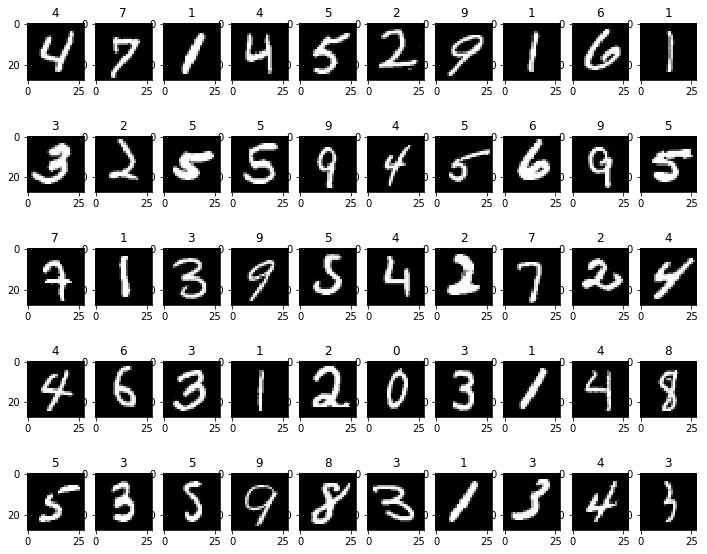

In [5]:
%matplotlib inline
plt.figure(figsize=(12,10))

y, x = 5,10
for i in range(0,(y*x)):
    plt.subplot(y, x, i+1)
    ni = np.random.randint(0,train_x.shape[0],1)[0]
    show_image(train_x[ni],(28,28), train_y[ni], cmp="gray")
plt.show()

### COUNT OF EXAMPLES PER DIGIT

Count of number the examples per digit is important, because if the data isn't uniform we can have a bad accuracy. In this dataset the number of examples per digit is uniform, so we won't worry.

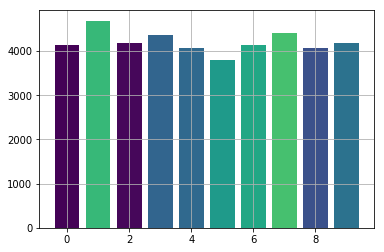

In [6]:
def count_exemple_per_digit(exemples):
    hist = np.ones(10)

    for y in exemples:
        hist[y] += 1

    colors = []
    for i in range(10):
        colors.append(plt.get_cmap('viridis')(np.random.uniform(0.0,1.0,1)[0]))

    bar = plt.bar(np.arange(10), hist, 0.8, color=colors)

    plt.grid()
    plt.show()

count_exemple_per_digit(train_y)

### NORMALIZATION

The precision of the computers is increasing, but isn't perfect. If we set 1e9 (1 billion), add 1e-6 to it million (1e6) times, and after subtract 1e9 (billion) from it, mathematically you should get 1 but we get 0.95... It happens because we add a lot of times a small number in a big number, breaking the precision of the computer.

In [7]:
num = 1e9

for i in range(1000000):
    num += 1e-6

num -= 1e9

print(num)
    

0.95367431640625


It can be a problem, because Neural Network uses a lot of sum. So, we have used normalization techniques for solving it. In general is a good practice normalize of the data with mean zero and a small variance.

For image exists a very easy normalization, how the values of an image is between 0 - 255, we just divide by 255. With this normalization the values of the images are between 0 - 1.

In [8]:
def normalization(x, mu, sigma):
    
    x_norm = np.zeros_like(x)

    for n in range(len(x)):
        for j in range(len(x[n])):
            if(sigma[j]!=0):
                x_norm[n,j] = (x[n,j] - mu[j]) / sigma[j]
            else:
                x_norm[n,j] = 0
                    
    return x_norm

In [9]:
mu = np.mean(train_x, axis=0)
sigma = np.max(train_x, axis=0)-np.min(train_x, axis=0)

In [10]:
test = normalization(test, mu, sigma)

In [11]:
train_x = normalization(train_x,mu, sigma)

In [12]:
print("Test Min: %.2f" % np.min(test))
print("Test Max: %.2f" % np.max(test))
print("Train Min: %.2f" % np.min(train_x))
print("Train Max: %.2f" % np.max(train_x))

Test Min: -0.55
Test Max: 5.17
Train Min: -0.55
Train Max: 1.00


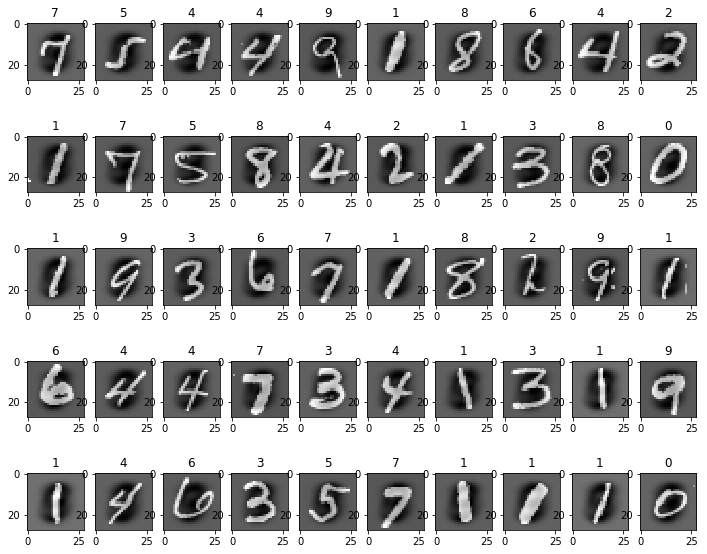

In [13]:
%matplotlib inline
plt.figure(figsize=(12,10))

y, x = 5,10
for i in range(0,(y*x)):
    plt.subplot(y, x, i+1)
    ni = np.random.randint(0,train_x.shape[0],1)[0]
    show_image(train_x[ni],(28,28), train_y[ni], cmp="gray")
plt.show()

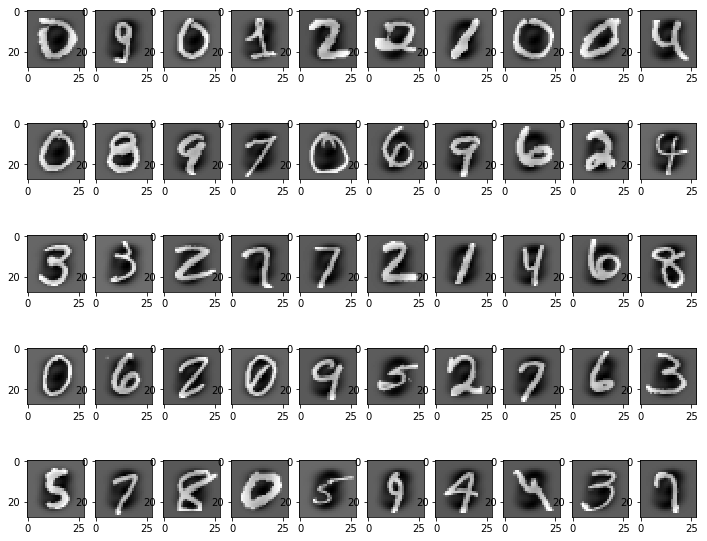

In [14]:
%matplotlib inline
plt.figure(figsize=(12,10))

y, x = 5,10
for i in range(0,(y*x)):
    plt.subplot(y, x, i+1)
    ni = np.random.randint(0,test.shape[0],1)[0]
    show_image(test[ni],(28,28),  cmp="gray")
plt.show()

### ONE HOT ENCODING

One Hot Encodding or Dummies is a group of the digits when each digit corresponds the propabilite of the class is True. It's very used for classifying. To do it, we'll use the pandas.

In [15]:
train_y = pd.get_dummies(train_y).as_matrix()
print(train_y[0])

[0 1 0 0 0 0 0 0 0 0]


## DEFINING THE MODEL

Artificial Neural Network or Neural Network(ANN or NN) is a branch of Machine Learning, that it is inspired by the biological neural networks. The NN consist of the conection of artifical neurons divide in layers. The most famous neuron is the perceptron. 

The artificial neuron consist in simulate the function of the biological neuron. The biological neural learn with its connections, if the connections is enough strong the signal is activate. In artificial neurons this feature is representate with variable Weght (wi), that they are changed in the training. These Weights represente the knowlegde of the Neural Networks.

Mathematically a artificial neuron can be represented by the sum of product between Input values and its respective weight, as equation bellow.

$$ Z = \sum_{i=1}^{n} X_i \cdot W_i + b_i$$ 
<br/>
In the artificial neuron contain the activation function, when the Z is apply. Exist a lot of activation functions, most famous are Sigmoid, Tahn, ReLu, LReLu and PReLu.

The derivative of the Z will be important for train the model.

$$ \dfrac{dZ}{dW} = X_i$$ 

![image.png](attachment:image.png)

Fonte: <a style='color:#003d99'>http://www.theprojectspot.com/tutorial-post/introduction-to-artificial-neural-networks-part-1/7</a>

### ACTIVATION FUNCTIONS

Exist a lot of types of activations functions, but in this model we'll use the ReLu  (Rectifier Linear Function), this function is similar to the functioning of the biological neuron, and allow us to run the model more fast. 

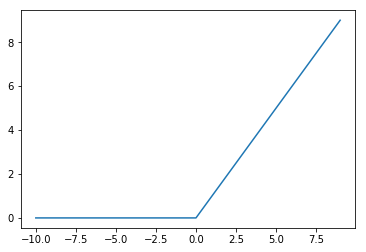

In [16]:
def ReLu(x, derivative=False):
    if(derivative==False):
        return x*(x > 0)
    else:
        return 1*(x > 0)

x = np.arange(20)-10
relu = ReLu(x)

plt.plot(x, relu)
plt.show()

The Softmax function allow us predict the model, because it normalize the data in one hot encoding.

$$ y = \sigma(x) = \dfrac{e^x}{\sum_{i=1}^{N} e^x}  $$

The derivative of the σ(x) will be important for train the model.

$$ \dfrac{dy}{dZ} = \dfrac{d\sigma(x)}{dZ} = \dfrac{e^x.\sum_{i=1}^{N} e^x - e^x. e^x}{[\sum_{i=1}^{N} e^x]^2}$$
$$ \dfrac{d\sigma(x)}{dZ} = \dfrac{e^x.(\sum_{i=1}^{N}  e^x. e^x)}{\sum_{i=1}^{N} e^x.\sum_{i=1}^{N} e^x} $$
$$ \dfrac{d\sigma(x)}{dZ} = \dfrac{e^x}{\sum_{i=1}^{N} e^x }. \dfrac{(\sum_{i=1}^{N}  e^x - e^x)}{\sum_{i=1}^{N} e^x} $$
$$ \dfrac{d\sigma(x)}{dZ} = \dfrac{e^x}{\sum_{i=1}^{N} e^x }. (\dfrac{(\sum_{i=1}^{N}  e^x)}{\sum_{i=1}^{N} e^x}-\dfrac{e^x}{\sum_{i=1}^{N} e^x}) $$
$$ \dfrac{d\sigma(x)}{dZ} = y. (1-y) $$


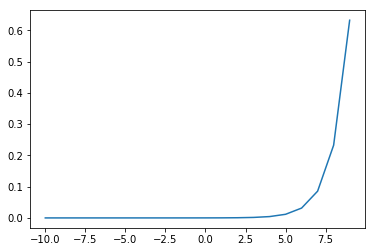

In [17]:
def Softmax(x):
    x -= np.max(x)
    sm = (np.exp(x).T / np.sum(np.exp(x),axis=1)).T
    return sm

x = np.arange(20)-10
softmax = Softmax([x])

plt.plot(x, softmax[0])
plt.show()

### DESCRIBE THE MODEL

In this link <a style='color:#003d99'>http://yann.lecun.com/exdb/mnist/</a> we can see some examples of models and yours respectives error in porcent. In this website the bests models are using the Convolution Neural Network, but it isn't the goal this Notebook. 

In this notebook we will use a Neural Network with 3 layer, 800-300 Hidden Units with Softmax Classification, Cross-Entropy as Loss Function and weight decay, as describe by Hinton, unpublished, 2005. Where he got 1,53% porcent error in this Neural Network.

####   CREATING WEIGHTS 
<br/>
To simplify and helpin the calculus, we are use the matriz representation for representate the weights, inputs and the outputs.
In the method below will create the weights and the biases with mean zero and the variance proportional to root of the numbers of inputs. This method use the Numpy to create the ramdom number with normal function. This method return a list with the weights and biases.

In [18]:
def CreateWeights():
    ##Initialization of the Weights and the Biases with the random gaussian function with mean zeron, and variance between 1/sqtr(num_inputs_layer)
    
    ninputs = 784
    wl1 = 500 ##Number of neurons in the first layer
    wl2 = 300 ##Number of neurons in the second layer
    nclass = 10 ##Numer of the class, in this case it is the number of the digits.
    
    #layer1
    w1 = np.random.normal(0, ninputs**-0.5, [ninputs,wl1])
    b1 = np.random.normal(0, ninputs**-0.5, [1,wl1])
    
    #Layer2
    w2 = np.random.normal(0, wl1**-0.5, [wl1,wl2])
    b2 = np.random.normal(0, wl1**-0.5, [1,wl2])

    #Layer3
    w3 = np.random.normal(0, wl2**-0.5, [wl2,nclass])
    b3 = np.random.normal(0, wl2**-0.5, [1,nclass])
    
    return [w1,w2,w3,b1,b2,b3]

#### DROPOUT
<br/>
Dropout is a simple technique for prevent overfitting, it was approached in the paper "Dropout: A Simple Way to Prevent Neural Networks from Overfitting"<a style='color:#003d99'>(https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf)</a>.
This technique consist in randomly dropping neurons, for that layer not to depend of these neurons, to predict right.
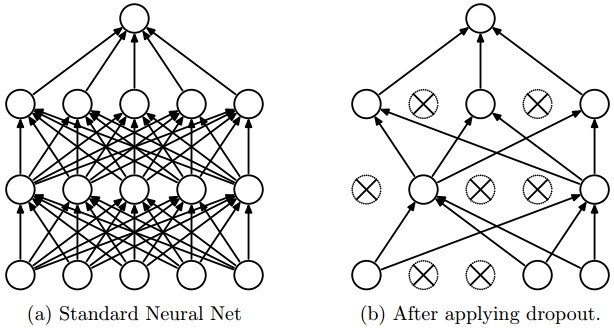

In [19]:
def Dropout(x, dropout_percent):
    mask = np.random.binomial([np.ones_like(x)],(1-dropout_percent))[0]  / (1-dropout_percent)
    return x*mask

#### PREDICT
<br/>
The model will be a Neural Network with 2 layers Fully Connected with  respectively, 500 and 300 neurons, the boths layers with Activation Function  ReLu. The last layer contain 10 neurons and used the Activation Function Softmax. Between the layer we will use the Dropout for prevent overfitting.

> 500 NN - DROPOUT- 300 NN - DROPOUT - 10 NN

How we are using the matrix representation, we have to use the matrix multiplication. The matrix 

In [20]:
def predict(weights, x, dropout_percent=0):
    
    w1,w2,w3,b1,b2,b3  = weights 
    
    #1-Hidden Layer
    first = ReLu(x@w1+b1)
    first = Dropout(first, dropout_percent)

    #2-Hidden Layer
    second = ReLu(first@w2+b2)
    second = Dropout(second, dropout_percent)
    
    #Output Layer
    return [first, second, Softmax(second@w3+b3)]

#### METRICS
<br/>
After to run the model we need to evaluate the model for measure how well the it is going, we can use the accuracy metric and / or loss metric.
The accuracy is measure by the percent of the hit of the model did, and we can measure with the function bellow.

In [21]:
def accuracy(output, y):
    hit = 0
    output = np.argmax(output, axis=1)
    y = np.argmax(y, axis=1)
    for y in zip(output, y):
        if(y[0]==y[1]):
            hit += 1

    p = (hit*100)/output.shape[0]
    return p

Exist a lot of loss functions, but as the variance of the numbers of inputs are small the changes will be small also, so we chose the cross-entropy as loss function, because it have high sensibility by small changes. The cross-entropy is used with probability, and compare the outputs of the model with the true results and return the distorcing of the diference.

$$ L(t|y) = - \dfrac{1}{N}. \sum_{i=1}^{N} [t \cdot log(y) + (1-t) \cdot log(1-y)] $$

Where, **N** is the number of the exemples, **t** is the right labels and **y** is the predict labels.

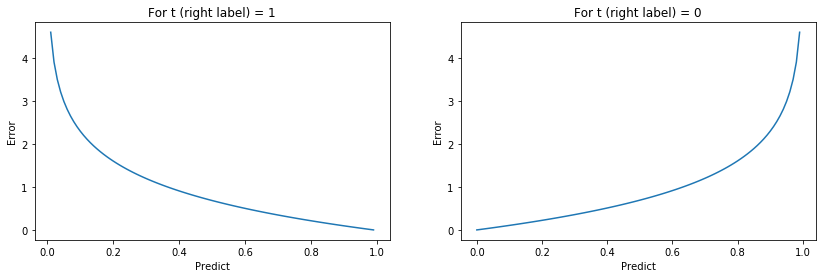

In [22]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(14, 4))

y = np.arange(100)/100

e = -np.log(y)
e2 = -np.log(1-y)

ax0.plot(y, e)
ax0.set_title("For t (right label) = 1")
ax0.set_xlabel("Predict")
ax0.set_ylabel("Error")
ax1.plot(y, e2)
ax1.set_title("For t (right label) = 0")
ax1.set_xlabel("Predict")
ax1.set_ylabel("Error")
plt.show()

This Loss function works well, but we need to be careful with the **log()**, because the log of the number zeros isn't exist so we consider **log(0)** as the lowest value -inf after use the np.nan_to_num().

The derivative of the L(t|y) will be important for train the model.

$$ \dfrac{dL(t|y)}{dy}  = \dfrac{1}{N}. \dfrac{t}{y}-\dfrac{(1-t)}{(1-y)} $$
$$ = \dfrac{1}{N}. \dfrac{t.(1-y) - (1-t).y}{y.(1-y)} $$
$$ = \dfrac{1}{N}. \dfrac{t-ty - y+ty}{y.(1-y)} $$
$$ = \dfrac{1}{N}. \dfrac{t - y}{y.(1-y)} $$

http://users.isr.ist.utl.pt/~wurmd/Livros/school/Bishop%20-%20Pattern%20Recognition%20And%20Machine%20Learning%20-%20Springer%20%202006.pdf pg. 206

In [23]:
def log2(x):
    if(x!=0):
        return np.log(x)
    else:
        return -np.inf
    
def log(y):
    return [[log2(nx) for nx in x]for x in y]

def cost(Y_predict, Y_right, weights, nabla):
    w1,w2,w3,b1,b2,b3  = weights
    weights_sum_square = np.mean(w1**2) + np.mean(w2**2) + np.mean(w3**2)
    Loss = -np.mean(Y_right*log(Y_predict) + (1-Y_right)*log(1-Y_predict)) + nabla/2 *  weights_sum_square
    return Loss

#### CROSS - VALIDATION
<br/>
The cross-validation is a techinique used for measure the accuracy and visualization overfitting. This technique consist in split the data in train_data anda test_data, where the test_data consist of 10% - 30% of the all data.

In [24]:
porcent_valid = 0.1
VALID_SIZE = round(train_x.shape[0]*porcent_valid)

index_data = np.arange(train_x.shape[0])
np.random.shuffle(index_data)

x_train = train_x[index_data[VALID_SIZE:]]
x_valid = train_x[index_data[:VALID_SIZE]]


d_train = train_y[index_data[VALID_SIZE:]]
d_valid = train_y[index_data[:VALID_SIZE]]

train_x = None
train_y = None

x_train.shape

(37800, 784)

## TRAINING
### SGD (Stochastic Gradient Descent)

SGD is a optimizer used for fit the neural network, this technique is based by Gradient Descent.
In SGD is used the matriz representation, the equation for represent the update the weights is bellow.

$$ V_{k+1} = V_k - \eta . \nabla L(W_{ij}) $$
<br/>
$$  W = V_{k+1}  $$

Where the **η** is the step size, and the **∇L(W)** is the gradient of the Loss.

The gradient can be solved using the chain rule of the derivate the Loss funtion by Weights. The equation for output layer is bellow.

$$ \nabla L(W_{ij}) = \dfrac{dL(W_{ij})}{dW_{ij}} $$
<br/>
$$ =\dfrac{dL(t|y)}{dy}.\dfrac{dy}{dZ}.\dfrac{dZ}{dW_{ij}} $$
<br/>
$$ =\dfrac{1}{N} . \dfrac{(t-y)}{y.(1-y)}.y.(1-y). X_{ij} $$
<br/>
$$ = \dfrac{1}{N} . (t-y)X_{ij} $$
<br/>
<center>For the hidden layer:</center>
<br/>
$$ \nabla L(W_{ij}) = \dfrac{dL(W_{ij})}{dW_{ij}} $$
<br/>
$$ =\dfrac{dL(t|y_{ij})}{dy_{ij}}.\dfrac{dy_{ij}}{dZ_{ij}}.\dfrac{dZ_{ij}}{dy_{ij}}.\dfrac{dy_{ij}}{dZ_{ij}}.\dfrac{dZ_{ij}}{dW_{ij}} $$
<br/>
$$ = \dfrac{1}{N} . \dfrac{(t-y)}{y.(1-y)}.y.(1-y). W_{ij}.\sigma(x)'.X_{ij} $$
<br/>
$$ = \dfrac{1}{N} . (t-y).W_{ij}.\sigma(x)'.X_{ij} $$
<br/>
### MOMENTUM

The SGD in training have a lot of oscillations, so the momentum term was invented. The momentum term is used for soft the oscillations and accelerates of the convergence.

$$  V_{i+1} = \gamma V_i + \eta . \nabla L(W) $$ 
<br/>
$$  W = W - V_{i+1} $$
<br/>

### L2 REGULIZER 

The L2 regulizer is the technique which is used for penalize the higher weights, 

$$ L(t|y|w) = -\dfrac{1}{N} . \sum_{i=1}^{N} [(t \cdot log(y) + (1-t) \cdot log(1-y)) +\dfrac{\lambda}{2}. \sum_{j=1}^{nj}\sum_{i=1}^{ni} W_{ij}^2] $$

With this modification in the Loss function the equation of the update the weights is changed. 
For the output layer.
 
$$ \nabla L(W_{ij}) = \dfrac{1}{N} . [(t-y).X_{ij} + \lambda W_{ij}] $$

For the hidden layer.

$$ \nabla L(W_{ij}) = \dfrac{1}{N} . [(t-y).W_{ij}.\sigma(x)'.X_{ij} +  \lambda W_{ij} ] $$

In [25]:
def SGD(weights, x, t, outputs, eta, gamma, nabla, cache=None):
    
    w1,w2,w3,b1,b2,b3  = weights
    
    
    if(cache==None):
            vw1 = np.zeros_like(w1)
            vw2 = np.zeros_like(w2)
            vw3 = np.zeros_like(w3)
            vb1 = np.zeros_like(b1)
            vb2 = np.zeros_like(b2)
            vb3 = np.zeros_like(b3)
    else:
        vw1,vw2,vw3,vb1,vb2,vb3 = cache
    
    first, second, y = outputs
   
    w3_delta = (t-y)
   
    w2_error = w3_delta@w3.T
    
    w2_delta = w2_error * ReLu(second,derivative=True)

    w1_error = w2_delta@w2.T
    w1_delta = w1_error * ReLu(first,derivative=True)
    
    eta = -eta/x.shape[0]
 
    vw3 = gamma*vw3 + eta * (second.T@w3_delta + nabla*w3)
    vb3 = gamma*vb3 + eta * w3_delta.sum(axis=0)

    vw2 = gamma*vw2 + eta * (first.T@w2_delta + nabla*w2)
    vb2 = gamma*vb2 + eta * w2_delta.sum(axis=0)

    vw1 = gamma*vw1 + eta * (x.T@w1_delta + nabla*w1)
    vb1 = gamma*vb1 + eta * w1_delta.sum(axis=0)
    
    
    w3 -= vw3
    b3 -= vb3

    w2 -= vw2
    b2 -= vb2

    w1 -= vw1
    b1 -= vb1
    
    weights = [w1,w2,w3,b1,b2,b3]
    cache = [vw1,vw2,vw3,vb1,vb2,vb3]
    
    return weights, cache

### Training process

In the training process is divided all the data in batchs, it's a process part because it's principle fundament of the stochastic process. These batchs need to be divide with randomlly for improved the accuracy of the model.

### Image Transformation

Simard, Steinkraus and Platt in yours paper "Best Practices for Convolutional Neural Networks applied to Visual Document Analysis"(http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.10.5032&rep=rep1&type=pdf) show that the transformation images can improved the Neural Network. In yours tests the Elastic Transformation showed the best results.

I found out in the github a method that implement the elastic transformation. (https://gist.github.com/fmder/e28813c1e8721830ff9c)

In [26]:
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter

def elastic_transform(image, alpha, sigma, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_.
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
       Convolutional Neural Networks applied to Visual Document Analysis", in
       Proc. of the International Conference on Document Analysis and
       Recognition, 2003.
    """
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha

    x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1))

    return map_coordinates(image, indices, order=1).reshape(shape)

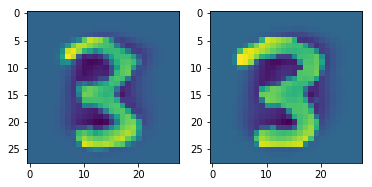

In [27]:
x_t = np.array([elastic_transform(xx.reshape(28,28),15,3).reshape(784) for xx in x_train[0:10]])
plt.subplot(1,2,1)
plt.imshow(x_t[0].reshape(28,28))
plt.subplot(1,2,2)
plt.imshow(x_train[0].reshape(28,28))

In [28]:

def run(weights, x_train, y_train, x_valid, y_valid, epochs = 10, nbatchs=25, alpha = 1e-3, decay = 0, momentum = 0, l2 = 0.001, dropout_percent = 0):
    
    pross = x_train.shape[0]*0.05
    
    history = [[],[]]
    
    index = np.arange(x_train.shape[0])
    cache = None
    print("Train data: %d" % (x_train.shape[0]))
    print("Validation data: %d \n" % (x_valid.shape[0]))
    mtime = 0
    
    r_weights = []
    max_accuracy_valid = 0
    
    for j in range(epochs):
        np.random.shuffle(index)
        t = 0
        iterations = round(x_train.shape[0]/nbatchs)
        prog = ""
        sacurr = 0
        sloss = 0
        sys.stdout.write("\nEpochs: %2d \ %2d \n"% (j+1,epochs))
        stime = 0
        timeIT = time.time()
        for i in range(iterations):
            timeI = time.time()
            f = i*nbatchs
            l = f+nbatchs
            
            if(l>(x_train.shape[0]-1)):
                l = x_train.shape[0]
                
            x = np.array([elastic_transform(xx.reshape(28,28),15,3).reshape(784) for xx in x_train[index[f:l]]])
            y = y_train[index[f:l]]

            outputs = predict(weights, x, dropout_percent)
            
            loss = cost(outputs[-1], y, weights, l2)
            
            
            accuracy_t = accuracy(outputs[-1], y)
            
            sacurr += accuracy_t
            sloss += loss
            
            accuracy_train = sacurr/(i+1)
            loss_train = sloss/(i+1)
            
            weights, cache = SGD(weights, x, y, outputs, alpha, momentum, l2, cache)
            
            t+= x.shape[0]
            
            qtd = round(t/pross)
            prog = "["
            for p in range(20):
                if(p<qtd-1):
                    prog += "="
                elif(p==qtd-1):
                    prog += ">"
                else:
                    prog += "."
            prog += "]"

            
            stime += time.time()-timeI
            mtime = stime/(i+1)
            mTimeT = mtime * (iterations-i-1)
            
            sys.stdout.write("\r%5d/%5d %s ETA: %3d s - loss: %.4f  acc: %.4f" % (t, x_train.shape[0], prog, mTimeT, loss_train, accuracy_train))
            
            history[0].append([loss_train, accuracy_train])
        mtime = time.time()-timeIT
        alpha = alpha - (alpha*decay)
        
        outputs = predict(weights, x_valid)
        
        loss_valid = cost(outputs[-1], y_valid, weights, l2)
        accuracy_valid = accuracy(outputs[-1], y_valid)
        
        sys.stdout.write("\r%5d/%5d %s ETA: %3d s loss: %.4f  acc: %.4f - lossValid: %.4f  accValid: %.4f " % ( t, x_train.shape[0], prog, mtime, loss_train, accuracy_train, loss_valid, accuracy_valid))
        history[1].append([loss_valid, accuracy_valid])
            
        if(accuracy_valid>=max_accuracy_valid):
            w1,w2,w3,b1,b2,b3  = weights
            r_weights = [w1.copy(),w2.copy(),w3.copy(),b1.copy(),b2.copy(),b3.copy()]
            max_accuracy_valid = accuracy_valid
        
    return r_weights, history

In [29]:
weights = CreateWeights()

alpha = 0.1   # alpha = 5e-2
epochs = 10    # epochs = 40
nbatchs = 1000 # nbatchs = 100
weights, history = run(weights, 
              x_train, d_train, 
              x_valid, d_valid, 
              epochs = epochs,
              nbatchs=nbatchs, 
              alpha = alpha, 
              decay = 0.05, 
              momentum = 0.9, 
              l2 = 1e-3, 
              dropout_percent = 0.20)

Train data: 37800
Validation data: 4200 


Epochs:  1 \ 10 
37800/37800 [===================>] ETA: 226 s loss: 0.1942  acc: 61.3763 - lossValid: 0.0614  accValid: 88.7619 
Epochs:  2 \ 10 
37800/37800 [===================>] ETA: 224 s loss: 0.0834  acc: 84.1322 - lossValid: 0.0393  accValid: 93.0000 
Epochs:  3 \ 10 
37800/37800 [===================>] ETA: 224 s loss: 0.0656  acc: 87.8974 - lossValid: 0.0297  accValid: 95.0952 
Epochs:  4 \ 10 
37800/37800 [===================>] ETA: 224 s loss: 0.0572  acc: 89.5349 - lossValid: 0.0255  accValid: 95.6190 
Epochs:  5 \ 10 
37800/37800 [===================>] ETA: 257 s loss: 0.0507  acc: 90.7658 - lossValid: 0.0218  accValid: 96.3571 
Epochs:  6 \ 10 
37800/37800 [===================>] ETA: 239 s loss: 0.0470  acc: 91.5474 - lossValid: 0.0194  accValid: 96.6429 
Epochs:  7 \ 10 
37800/37800 [===================>] ETA: 227 s loss: 0.0438  acc: 92.1224 - lossValid: 0.0181  accValid: 96.8810 
Epochs:  8 \ 10 
37800/37800 [=================

In [30]:
train_history = np.array(history[0])
t_loss = train_history[:,:1]
t_acc = train_history[:,1:2]

In [31]:
valid_history = np.array(history[1])
train_history.shape
v_loss = valid_history[:,:1]
v_acc = valid_history[:,1:2]

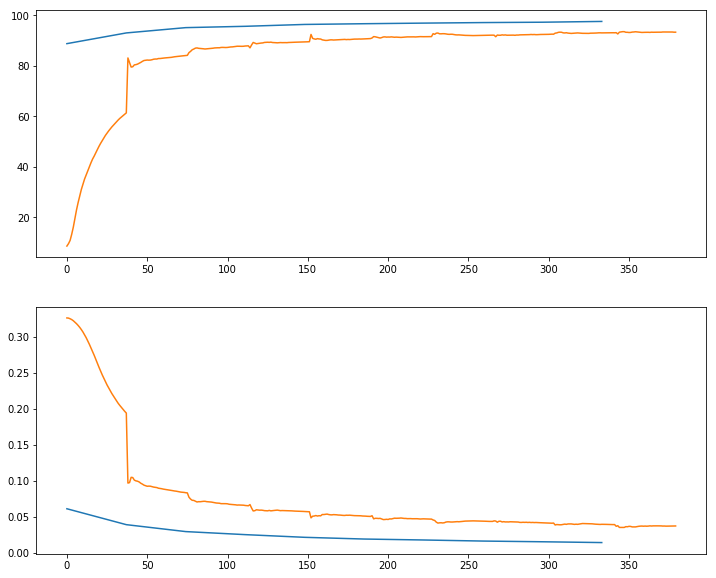

In [32]:
plt.figure(figsize=(12,10))

plt.subplot(2, 1, 1)
x = np.arange(epochs)*int(x_train.shape[0]/nbatchs)
plt.plot(x,v_acc)
plt.plot(t_acc)

plt.subplot(2, 1, 2)
plt.plot(x,v_loss)
plt.plot(t_loss)

plt.show()

In [33]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [34]:
outputs = predict(weights, x_valid)

In [35]:
p = np.argmax(outputs[-1],axis=1)
predict_dummies = pd.get_dummies(p).as_matrix().astype('int8')

cm = np.zeros((10,10)).astype(np.int64)

d_valid_int = np.argmax(d_valid, axis=1)

for i in range(predict_dummies.shape[0]):
    cm[d_valid_int[i]] += predict_dummies[i]

print(cm)

[[418   0   1   0   0   0   2   0   0   0]
 [  0 434   1   4   2   0   1   1   1   0]
 [  1   2 405   0   2   0   0   1   0   0]
 [  0   0   3 435   0   5   0   7   3   1]
 [  0   0   0   0 402   0   0   0   0   4]
 [  1   0   1   4   1 375   4   0   0   1]
 [  1   0   0   0   1   3 400   0   0   0]
 [  1   0   7   1   0   0   0 429   0   6]
 [  1   3   1   4   3   3   1   0 396   2]
 [  2   0   0   2   0   0   0   3   4 403]]


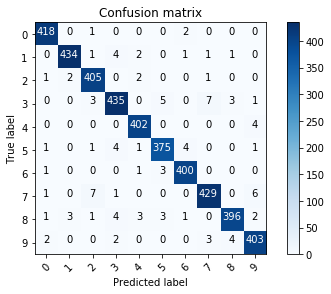

In [36]:
plot_confusion_matrix(cm, range(10))

In [37]:
s_cm = np.sum(cm,axis=0)
for i in range(10):
    p = cm[i][i]/s_cm[i]
    print("%d - %.3f %%" % (i,p))

print(" ");
print("%f %%" % accuracy(outputs[-1], d_valid))

0 - 0.984 %
1 - 0.989 %
2 - 0.967 %
3 - 0.967 %
4 - 0.978 %
5 - 0.972 %
6 - 0.980 %
7 - 0.973 %
8 - 0.980 %
9 - 0.966 %
 
97.547619 %


In [38]:
w1,w2,w3,b1,b2,b3  = weights

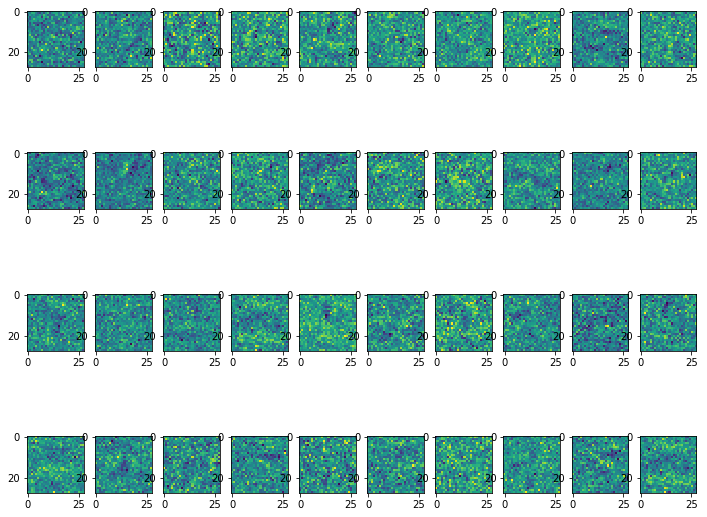

In [39]:
%matplotlib inline
plt.figure(figsize=(12,10))

y, x = 4,10
for i in range(0,(y*x)):
    ni = np.random.randint(0,w1.shape[1],1)[0]
    plt.subplot(y, x, i+1)
    plt.imshow(w1[:,ni].reshape((28,28)))

plt.show()

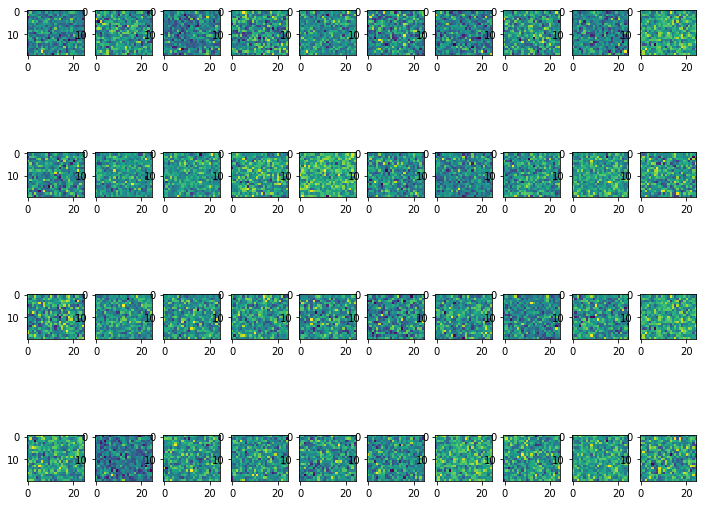

In [40]:
%matplotlib inline
plt.figure(figsize=(12,10))

y, x = 4,10
for i in range(0,(y*x)):
    ni = np.random.randint(0,w2.shape[1],1)[0]
    plt.subplot(y, x, i+1)
    plt.imshow(w2[:,ni].reshape((20,25)))

plt.show()

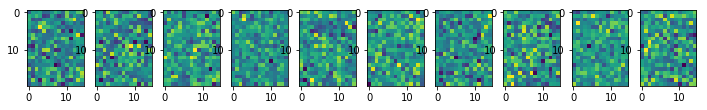

In [41]:
%matplotlib inline
plt.figure(figsize=(12,10))

y, x = 1,10
for i in range(0,(y*x)):
    plt.subplot(y, x, i+1)
    plt.imshow(w3[:,i].reshape((20,15)))

plt.show()

In [42]:
outputs = predict(weights, test)


In [43]:
d = np.argmax(outputs[-1],axis=1)

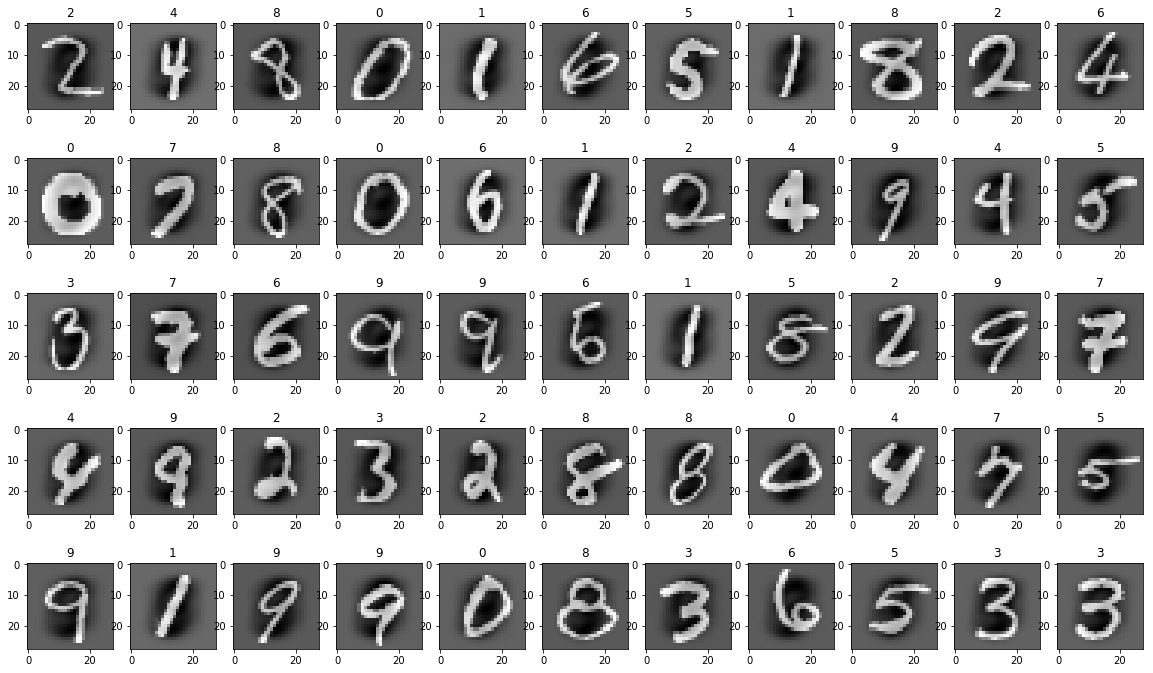

In [44]:
%matplotlib inline
plt.figure(figsize=(20,12))

y, x = 5,11
for i in range(0,(y*x)):
    plt.subplot(y, x, i+1)
    ni = np.random.randint(0,test.shape[0],1)[0]
    v = str(d[ni])
    show_image(test[ni],(28,28), v, cmp="gray")
plt.show()

In [45]:
#ImageId,Label

pd.DataFrame({"ImageId": list(range(1,len(d)+1)), "Label": d}).to_csv('output.csv', index=False, header=True)

## REFERENCES

http://users.isr.ist.utl.pt/~wurmd/Livros/school/Bishop%20-%20Pattern%20Recognition%20And%20Machine%20Learning%20-%20Springer%20%202006.pdf